In [9]:
import os
import emcee
import rebound
import numpy as np
import pandas as pd
from numba.typed import List
from numba import jit, types
import astropy.constants as ast
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Getting the current working directory and the path to the data.
currDir = os.getcwd()

We are modelling the system of Kepler 33, which has five planets, sublabelled 'b', 'c', 'd', 'e', 'f'.

# Handling and Formatting the Transit Timings from Kepler 33
The original transit timings have slight variations to the predicted values because of their interactions with the other planets in the system, Kepler 33. These are called Transit Timing Variations (TTVs)!
- For our eccentricity and for the mass of the planets and the mass of the star, the majority of our data is taken from https://arxiv.org/pdf/2211.00703, and if data was not available, we sourced it from nasa.gov.
- We didn't use data for the semi-major axis (a) because Rebound takes either the period or a as a parameter and our period is much much better determined. 

In [10]:
conNum = lambda arr, idx: np.array(arr, dtype=object)[idx]

def get_transitTimingData(path):
    '''
    Extracting the timing data. One column gives the predicted transits and the other gives
    the predicted minus the observed, and the last one gives the errors in timings.
    '''
    predArr, t0Arr, errArr = [], [], [] # the predictions versus the actual versus the errors

    for file in os.listdir(path):
        d = np.loadtxt(path+'/'+file)
        predArr.append(d[:, 0]), t0Arr.append(d[:, 0] + d[:, 1]), errArr.append(d[:, 2])
    
    # Find the period of the data, which should be the smallest difference
    P = np.array([np.min(arr[1:] - arr[:-1]) for arr in predArr])
    # We sort by the period because the data files are not in order. 
    sIdx = np.argsort(P)
        
    return P[sIdx], conNum(predArr, sIdx), conNum(t0Arr, sIdx), conNum(errArr, sIdx)

# Load in the data.
P, pred, t0, err = get_transitTimingData(currDir + '/koi707_timing')
# However, we normalise our simulation data to begin at the first transit, which is f.
tranTime1 = np.array([arr[0] for arr in pred])
minTran = np.min(tranTime1)

# We define the following values for the planets, e = eccentricity, m = planet masses.
exoNames = ['b', 'c', 'd', 'e', 'f']
# This is the upper bound for the eccentricity, so it becomes our prior. are the upper bounds 
global eccPrior # We make it a global variable because we use it later for our MCMC. 
eccPrior = np.array([0.2, 0.05, 0.03, 0.02, 0.02])
ecc = eccPrior/3
# These are our upper and lower bounds for our masses, and we use them as our priors.
global mLowerPrior, mUpperPrior
mLowerPrior, mUpperPrior = np.array([0.1, 0.1, 0.1, 6.6-1.0, 8.2-1.2]), np.array([20, 19, 8.2, 6.6+1.1, 8.2+1.6])
m = np.array([3.68, 18.3, 7.5, 6.6, 8.2])

# Orbital Elements!
Before we define our orbital elements, we define our system,
- The reference plane is the tangent to the celestial sphere in which we see the orbit.
- The orbit intersects the reference plane at two points, the orbital plane intersects the reference plane along a line. 
- Ascending node: where the orbit passes upwards through the reference plane.
- Descending node: where the orbit passes downwards through the reference plane.

## Definition
Eccentricity (e): shape of the ellipse, how elongated it is.   
Semi-major axis (a):  half the distance between the apoapsis (furtherest) and periapsis(closest), akin to the radius of a circle - not used as explained above.           
Inclination (i): the up and down (vertical tilt) to the reference plane, i.e. the angle between the orbital plane and the reference plane?      
Longitude of the ascending node (Ω): how rotated is the orbital plane on the reference plane?     
Argument of periapsis (ω): the angle between the ascending node to the periapsis (the closest point the satellite body comes to the primary body around which it orbits).     
True anomaly (ν, θ, or f): the epoch (t0), defines the position of the orbiting body along the ellipse at a specific time (the "epoch"), expressed as an angle from the periapsis.     

## Simplifying the System
For our use, we assume that the orbital plane is perpendicular to the reference plane for the best possible view of transit. 
- The longitude of the ascending node does not matter, because our transit signal will be the same no matter what. It does matter when i isn’t 90 degrees because it will affect the transit curve.
The argument of periapsis is defined as where we observe our T0, because of our calculation of f.
- Another approximation we make is the mean ananomaly, M, approximately equal to the eccentricity ananomaly, E, in order to calculate f. We can do this because our eccentricity is quite small. 

In [4]:
def fCalc(b4T0, P, e):
    '''
    To approximate the starting positions. First, we find the mean ananomaly, taking T0 as periapsis.
    Then, we approximate the eccentric ananomaly as the mean ananomaly as e is small. We then directly
    derive our true ananomaly from our eccentric ananomaly, given as the alternate form from
    https://en.wikipedia.org/wiki/True_anomaly
    '''
    M = (P - b4T0)/P # mean ananomaly approximately eccentric ananomaly when e is small.
    # The calculation to derive the true 
    beta = e/(1+np.sqrt(1-e**2))
    temp = beta*np.sin(M)/(1-beta*np.cos(M))
    f = M + 2*np.arctan(temp)
    
    return f

# Out of the orbital elements we need, we're only missing f!
f = fCalc(tranTime1-minTran, P, ecc) # f gives us our initial position.
# These are the orbital elements that we feed into the rebound simulation. 
orbitalElements = [m*ast.M_earth.value/ast.M_sun.value, P, ecc, np.full((len(exoNames),), np.pi/2), f]
# Note that the constants are given by astropy: https://docs.astropy.org/en/stable/constants/index.html

# REBOUND

## Setting up the simulation 
We use Rebound to set up our nBody simulation.
- A paper introducting Rebound is here - https://www.aanda.org/articles/aa/abs/2012/01/aa18085-11/aa18085-11.html
- Our use of the orbital elements is here - https://rebound.readthedocs.io/en/latest/ipython_examples/OrbitalElements/ - this is why we calculated the specific parameters above.
- Its github is here - https://github.com/hannorein/rebound/?tab=readme-ov-file

The positions of the orbits at our time steps are saved in order for us to visualise the data, we can plot these. The eccentricity of our orbits are low, and so they don't interact greatly with each other. 

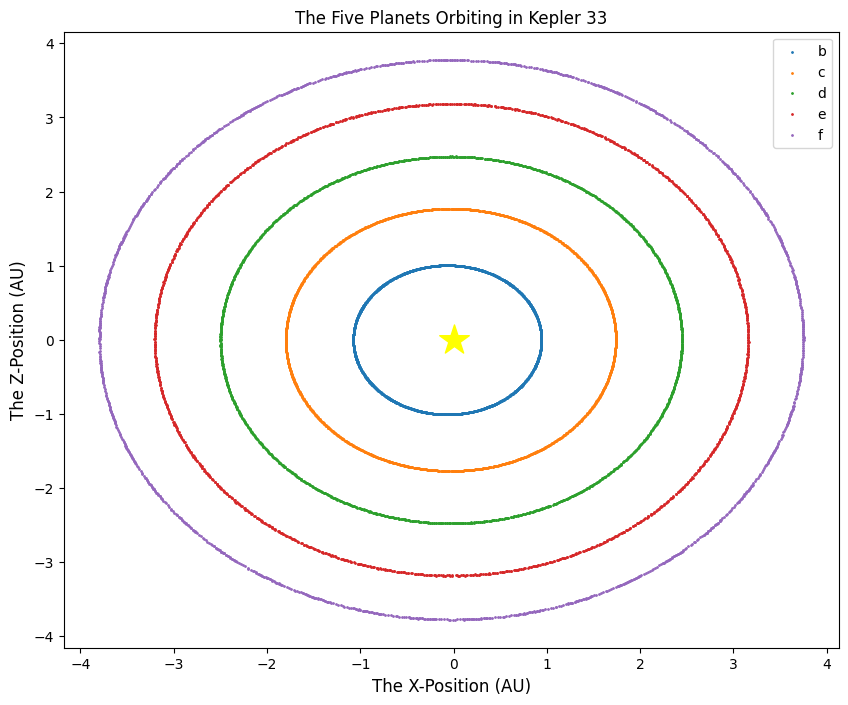

In [14]:
def solve_nBody(orbE, star=False):
    '''
    Set up our system, choosing our integrator and adding our star. Subsequently, we can populate the simulation
    with planets. We use Rebound to solve for the positions of our planets, thus solving the 5 body system. 
    '''
    kep33 = rebound.Simulation() # This sets up our system
    kep33.integrator = 'whfast'
    # Our star is at the centre of the system with no velocity etc, so no orbital elements for it except mass.
    kep33.add(m=1.26) # The units are in solar masses.
    
    # Populating the simulation with our planets. 
    for i, colName in enumerate(exoNames):
        # Plugging in our orbital parameters.
        kep33.add(m=orbE[0][i], P=orbE[1][i], e=orbE[2][i], inc=orbE[3][i], f=orbE[4][i])
 
    # Moving our system to the centre of mass frame, which should be in the star
    kep33.move_to_com() 
    
    # The Kepler mission ran for 4 years, so we run this for around the same time.
    timeStep = 0.01 # This sets each increment of time to one day, this is relatively coarse. 
    times = np.arange(0, 4*365, timeStep)
    N = len(times) # Number of iterations
    exoPos = np.zeros((N,5,2)) # An array that saves the positions of the planets at each time. 
    
    # Solving the system we set up. 
    for i, t in enumerate(times):
        kep33.integrate(t) # We integrate to each of the time steps to find the planet positions.
        for j in range(exoPos.shape[1]):
            # We save the x and y positions of the planets into the array, we do not save the star.
            exoPos[i, j] = np.array([kep33.particles[j+1].x, kep33.particles[j+1].z])
    
    if star:
        return exoPos, timeStep, (kep33.particles[0].x, kep33.particles[0].z)

    return exoPos, timeStep

pTot, dt, starCoor = solve_nBody(orbitalElements, star=True)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(starCoor[0], starCoor[1], marker='*', c='yellow', s=500)
for i, exo in enumerate(exoNames):
    ax.scatter(pTot[:, i, 0], pTot[:, i, 1], label=exoNames[i], s=1)
ax.legend()
ax.set_xlabel('The X-Position (AU)', fontsize=12)
ax.set_ylabel('The Z-Position (AU)', fontsize=12)
ax.set_title('The Five Planets Orbiting in Kepler 33')
plt.show()

Wow!!! But we can visualise the orbits of Kepler 33 in motion.

# Our Animation
How did we do this?

#### 2D simulation

In [43]:
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 50.0  # 50 MB instead of the default 20 MB


earth_radius = 4.258756e-5
jupiter_radius = 4.676e-4 

# Create a list of planets with their colors and names for visualization
planet_properties = [
    {'color': 'sandybrown', 'name': 'Keppler-33 b','radius': 1.74*earth_radius},
    {'color': 'lightcoral', 'name': 'Keppler-33 c','radius': 3.2*earth_radius},
    {'color': 'slategray', 'name': 'Keppler-33 d','radius': 0.477*jupiter_radius},
    {'color': 'khaki', 'name': 'Keppler-33 e','radius': 0.359*jupiter_radius},
    {'color': 'plum', 'name': 'Keppler-33 f','radius': 0.398*jupiter_radius},
]

sun = 0.008464 # Radius Star of Kepler 33 in AU

p1 = pTot[:, 0, :]
p2 = pTot[:, 1, :]
p3 = pTot[:, 2, :]
p4 = pTot[:, 3, :]
p5 = pTot[:, 4, :]


planets_positions = [p1,p2,p3,p4,p5] # Array of planets 


# Create a figure for plotting
fig, ax = plt.subplots(figsize=(10, 10))  # Increase size here
ax.set_xlim(-5,6)
ax.set_ylim(-5,5)

# ax.set_xlim(-0.3, 0.3)
# ax.set_ylim(-0.3, 0.3)
ax.set_aspect('equal')
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')

import time
# Plotting function to update positions
call_counter = 0
def update(frame):
    global call_counter 
        
    call_counter += 1

    # Clear the previous plot
    ax.clear()
    
    # Re-draw the axes
    ax.set_xlim(-5,6)
    ax.set_ylim(-5,5)

    ax.set_aspect('equal')
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('z (AU)')
    
    ax.plot(0, 0, marker=(5,1), color='yellow', markersize=25, label='Star',linestyle='None')  # Sun at the center
    ax.set_facecolor('black')

    
    # Plot the orbits as grey dotted lines
    for i, planet in enumerate(planets_positions):
        # Calculate the distance from the Sun (Euclidean distance)
        x, y = planet[frame, 0], planet[frame, 1]  # Current position of the planet
        orbit_radius = np.sqrt(x**2 + y**2)
        
        # Plot the orbit as a grey dotted circle
        orbit = plt.Circle((0, 0), orbit_radius, color='white', linestyle=':', fill=False)
        ax.add_artist(orbit)
    
    
    # Update the positions of each planet
    for i, planet in enumerate(planets_positions): 
        x, y = planet[:,0][call_counter-1],planet[:,1][call_counter-1]
        ax.plot(x, y, marker='o', color=planet_properties[i]['color'], label=planet_properties[i]['name'], linestyle='None',
               markersize = (planet_properties[i]['radius']/sun)*1000)

    # Add legend and title
    ax.legend(loc='upper right',markerscale = 1/2)
    ax.set_title(f"Day {dt*(call_counter-1)}")

# Create an animation object
ani = FuncAnimation(fig, update, frames=np.arange(0, 1000, 1), interval=50, repeat=False)
#ani.save('planetary_orbits.mp4', writer='pillow', fps=30)  # Save the animation to a video file

# Display the animation inline in a Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


#### 3D Simulation (This a large file, it is saved in the repository)

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Example data: positions for each planet (planet_positions[i] = [[x0, y0], [x1, y1], ...])
# Each planet has a series of 2D positions over time (x, y) for each time step
# This is just an example of data structure; you need to replace it with your own data.
planets_positions = [p1,p2,p3,p4,p5]

planet_names = ['Keppler-33 b', 'Keppler-33 c', 'Keppler-33 d', 'Keppler-33 e', 'Keppler-33 f']
planet_colors = ['sandybrown', 'lightcoral', 'slategray', 'khaki', 'plum']
planet_radii = [3.1e-5, 4.2e-5, 2.8e-5, 1.5e-4, 5.3e-5]  # Example planet radii in AU
planet_colors = ['sandybrown', 'lightcoral', 'slategray', 'khaki', 'plum']

# Create a Plotly figure for 3D plot
fig = go.Figure()

# Add the Sun (static at the center)
fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[0],mode='markers',marker=dict(size=30,color='yellow',opacity=1),
    name='Star'))

# Create the frames for the animation
frames = []
for t in range(len(p1)):  # Assuming 50 time steps
    frame_data = []
    for i, name in enumerate(planet_names):
        # Get the position of the planet at time step `t`
        x = planets_positions[i][t, 0]  # x position of planet
        y = planets_positions[i][t, 1]  # y position of planet
        z = 0  # Assuming it's a 2D orbit, so z = 0 for simplicity
        radius = planet_radii[i]

        # Scale the size of the marker based on the planet's radius
        scaling_factor = 100000  # Adjust this to make the planets visible
        marker_size = radius * scaling_factor
        
        # Create a trace for this planet at time step `t`
        frame_data.append(go.Scatter3d(x=[x],y=[y],z=[z],mode='markers',marker=dict(size=marker_size,color=planet_colors[i],
                opacity=0.8), name=name))

    # Add this frame to the list of frames
    frames.append(go.Frame(data=frame_data, name=str(t)))

# Add frames to the figure
fig.frames = frames

# Set the initial trace for planets (at frame 0)
for i, name in enumerate(planet_names):
    fig.add_trace(go.Scatter3d(x=[planets_positions[i][0, 0]],y=[planets_positions[i][0, 1]],z=[0],  # Assuming a 2D orbit
        mode='markers',marker=dict(size=planet_radii[i] * 100000,color=planet_colors[i],opacity=0.8),name=name))

fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[0],mode='markers',marker=dict(size=30,color='yellow',opacity=1),
    name='Star'))

# Update layout for better presentation
fig.update_layout(
    title='3D Planetary Orbits',
    scene=dict(
        xaxis_title="x (AU)",
        yaxis_title="y (AU)",
        zaxis_title="z (AU)",
        xaxis=dict(range=[-5, 5]),  # Adjust the range according to your data
        yaxis=dict(range=[-5, 5]),
        zaxis=dict(range=[-0.1, 0.1])
    ),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    showlegend=True,
    legend=dict(
        x=1.05,
        y=0.5,
        traceorder='normal',
        font=dict(family="sans-serif", size=12, color="white"),
        bgcolor='rgba(0, 0, 0, 0.7)',
        bordercolor='white',
        borderwidth=2
    ),
    dragmode='orbit',
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None, dict(frame=dict(duration=100, redraw=True), fromcurrent=True)])]
    )]
)

# Show the plot
fig.show()


# Calculating the Transit Times
The goal from here is to use our model to fit the observational data of the system. The periods of the planets are relatively well-constrained but other parameters are not, which is why we wish to model the system with MCMC, and better understand what else is going on. To do this, we have the observational data we used to extract the period, an interesting note is that:
- we have the predicted transit times by the very well-determined period, however, the actual data varies from this.

## Why??
These are the TTVs! They allowed astronomers to detect the other planets in the system from the interactions. What we want to do is model the interactions between the planets to see if we can replicate these TTVs. If we can, that means we have a good data fit!

## Our calculation!

In [11]:
# Using jit to optimise our for loop!
@jit(nopython=True)
def getTransits(x, y, dt):
    '''
    With our (x,y) position from the data, we want to be able to find where the transits are. This allows us
    to compare our findings to the data. Define the transit to be at y=0 in the axis on the right (x positive)
    '''
    # The y values are actually z values when running the n body 
    # simulation according to our inclination value
    
    # For the values to be compatible with numba.
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    dt = float(dt)
    t_transit = List.empty_list(types.float64)
    
    # We verify that there are no y = 0 solutions, if there are, they are handled here. 
    if len(np.where(y == 0)[0]) != 0:
        zeroMask = np.logical_and(x>=0, y==0)
        indices = np.arange(len(y))[zeroMask]
        for idx in indices:
            # Adding time by taking the index (number of iterations) * change in t
            t_transit.append(float(idx * dt))
        
    else:
        # Getting array where y value changes sign
        index = np.where(np.diff(np.sign(y)))[0] 
        for i in index:
            if np.abs(x[i]) == x[i]: # Verifying if x is positive
                # Taking proportion to interpolate time value at y=0
                diff = np.abs(y[i]-y[i+1])
                prop = np.abs(y[i])/diff
                new_dt = prop*dt
                t = dt*(i)+new_dt #Time at index and additional time
                t_transit.append(float(t))                
    return t_transit

def systemTransits(orbPars):
    '''
    We put it all together in this function, where we compute the simulation and get our transit times from this.
    '''
    exoPos, dt = solve_nBody(orbPars)
    transits = []
    
    # Loop through this, so we compute the transits for each of the planets. 
    for j in range(exoPos.shape[1]):    
        tPlanet = getTransits(pTot[:, j, 0], pTot[:, j, 1], dt)
        transits.append(np.array(tPlanet))
    return np.array(transits, dtype=object)

#systemTransits(orbitalElements)

# Preparing for Our Markov chain Monte Carlo

## Matching the Observational Data to our Data (what?)
Occasionally, Kepler misses a transit and because of that, we have a time offset. Since our model doesn't miss these transits, we have to handle these cases. To do this,
- Find where Kepler misses a transit. This is where the difference is greater than the period.
- Once we determine this, we need to determine how many transits were missed and then add the suitable number of zeros at that point of the array.

## Our MCMC Functions

In [18]:
def padObs(t0, pred, err, period):
    '''
    Where we add zero values to where the difference is not the period, which is given by our predicted array.
    '''
    pDiff = pred[1:] - pred[:-1]
    pGreater = pDiff - period >= 10**-4
    numZeros = np.array(pDiff[pGreater]//period - 1, dtype=int)
    
    insertStartIdx = np.where(pGreater)[0] + 1
    insertIdx = np.array([], dtype=int)
    # We need to 'pad' out the insertIdx array to reflect the number of values to insert.
    for i, numZero in enumerate(numZeros):
        insertIdx = np.append(insertIdx, np.tile(0, numZero) + insertStartIdx[i])
    
    t0Corr = np.copy(t0)
    errCorr = np.copy(err)
    errInsert = t0[insertIdx - 1] # Basically the transit value after which we insert zeros.
    # Insert the value at the desired positions but as the array shifts, we need to enumerate.
    for i, idx in enumerate(np.array(insertIdx, dtype=int)):
        t0Corr = np.insert(t0Corr, idx+i, 0)  # Insert 0 behind the original value
        errCorr = np.insert(errCorr, idx+i, errInsert[i])  # Insert 0 behind the original value
    return t0Corr, errCorr

# We correct our observational data in order to match it to the model values here.
t0Corr, t0ErrCorr = [], []

for i in range(len(exoNames)):
    
    # Handling the padding situation. 
    padded, paddedErr = padObs(t0[i], pred[i], err[i], P[i])
    # Subtracting the initial offset that the model utilises to properly set up the system.
    padded[padded != 0] -= minTran
    t0Corr.append(padded)
    t0ErrCorr.append(paddedErr)
    
t0Corr = np.array(t0Corr, dtype=object)
t0ErrCorr = np.array(t0ErrCorr, dtype=object)
# Thus, we can define our data as:
data = (t0Corr, t0ErrCorr)

def lnlike(theta, y, yerr, orbE=orbitalElements):
    '''
    We organise our parameters and then plug them into our nBody simulation to get our simulated transits.
    We have to account for a difference in length between the original data and the simulated data. 
    '''
    params = np.array([theta[0], orbE[1], theta[1], orbE[3], theta[2]])
    ymodel = systemTransits(params)
    nPlan = len(ymodel)
    chiSq = np.zeros((nPlan,))
    
    for i in range(nPlan):
        
        planetMod = ymodel[i]
        if len(planetMod) > len(y[i]): # To match the lengths of the model versus the observed data. 
            planetMod = planetMod[:len(y[i])]
        elif len(planetMod) < len(y[i]):
            # This is an unlikely case and will hopefully not happen as we hold our period constant.
            y[i] = y[i][:len(planetMod)]
            yerr[i] = yerr[i][:len(planetMod)]

        # Will we keep this step or will we not? This is what determines this. 
        chiSq[i] = np.sum(((y[i] - planetMod)/yerr[i])**2)
    
#     print(chiSq)
#     print(np.sum(chiSq))
    
    LnLike = -0.5*np.sum(chiSq)
    file = open('chi_param_chain.txt', 'a') # Updating txt file
    file.write(str(chiSq)+'\t'+str(theta)+'\n')
    file.close()
    
    return LnLike

# Setting up boundary conditions
def lnprior(theta):
    '''
    Our priors decide whether or not our proposed values are valid. Our eccentricity values are less than our
    initial values, therefore, our prior must always be less than these values. 
    '''
    massCon = np.any(np.logical_and(mLowerPrior > theta[0], mUpperPrior < theta[0]))
    eccCon = np.any(theta[1] > eccPrior)
    # We want our true ananomaly to be between 0 and 2*pi because we want it to be within a circle. 
    fCon = np.any(np.logical_and(0 > theta[2], 2*np.pi < theta[2]))

    if massCon or eccCon or fCon:
        return -np.inf 
    return 0.0

def lnprob(theta, y, yerr, nExo=5):
    '''
    This calculates the probability of whether or not we take the step. This is done in several steps.
    We unpack and reshape our parameters and then test where or not they pass the priors. If they do not,
    then, the value is automatically discarded.
    '''
    thetaUnpacked = np.array([np.array(theta[:nExo]), np.array(theta[nExo:2*nExo]), np.array(theta[2*nExo:])])
    lp = lnprior(thetaUnpacked) # Checking if the priors have been satisfied. 
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(thetaUnpacked, y, yerr)

In [19]:
# Resetting file, so each time we write, it is better. 
reset = open("chi_param_chain.txt",'w')
reset.close()

# Adding title
file =  open('chi_param_chain.txt', 'a')
file.write('chi\tparam\n')
file.close()

def initWalkers(pars):
    '''
    We change the parameters by less than 5% because the random number is less than 1.
    '''
    offset = np.random.rand(*parInit.shape)*pars*0.05
    return (pars + offset).flatten()
    
# We begin with the initial parameters and will move from them as the chain progresses.
parInit = np.array([orbitalElements[0], orbitalElements[2], orbitalElements[-1]])
nPars = len(parInit.flatten()) # The number of parameters fitted.
nwalkers = nPars * 5 # We want the number of walkers to be at least five times the dimensions fitted.
walkerStart = [initWalkers(parInit) for i in range(nwalkers)] # Walker's start position

# Running the MCMC


In [17]:
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Running burn-in...")
    modP, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(modP, niter)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(walkerStart, nwalkers, 300, nPars, lnprob, data)

Running burn-in...
[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

[1.22952605e+04 1.65248851e+04 2.74848987e+04 1.64349025e+04
 2.41293840e+04 1.83668409e+04 1.73629475e-01 1.90785763e+04
 1.30824241e+04 2.56821900e-01 1.07368223e+04 1.41724361e+04
 1.52962531e+04 2.18332849e+04 2.01313942e+04 2.10562527e+04
 1.32492521e+04 1.88631837e+04 9.76209192e+03 1.84168155e+04
 1.91810674e+04 1.56898624e+04 1.84345324e+04 2.21241519e+04
 1.93897299e+04 1.30018992e+04 2.55151854e+04 1.64114229e+04
 5.63412037e-01 2.88827151e+04 1.50736270e+04 1.31349428e+04
 2.44470849e+04 1.23200426e+04 1.66918857e+04 1.91929702e+04
 1.71579726e+04 1.56201191e+04 2.29756658e+04 1.91423668e+04
 2.02605460e+04 1.07703726e+04 1.12983865e+04 1.58259012e+04
 1.44517742e+04 2.03625458e+04 1.93349034e+04 6.94430921e-01
 7.38146660e+03 1.13279898e+04 1.97394587e+04 1.28513388e+04
 1.71176180e+04 2.23509651e+04 1.77603948e+04 1.54446107e+04
 1.65623581e+04 4.56819213e+04 2.95565262e+04 2.51663996e+04
 2.26391520e+04 1.81980055e+04 2.12364608e+04 3.19778348e+04
 1.11840417e+04 2.038907

Traceback (most recent call last):
  File "/home/son/anaconda3/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_167187/3269601181.py", line 102, in lnprob
    return lp + lnlike(thetaUnpacked, y, yerr)
  File "/tmp/ipykernel_167187/3269601181.py", line 47, in lnlike
    ymodel = systemTransits(params)
  File "/tmp/ipykernel_167187/2735752800.py", line 39, in systemTransits
    exoPos, dt = solve_nBody(orbPars)
  File "/tmp/ipykernel_167187/75909427.py", line 27, in solve_nBody
    kep33.integrate(t) # We integrate to each of the time steps to find the planet positions.
  File "/home/son/anaconda3/lib/python3.10/site-packages/rebound/simulation.py", line 1397, in integrate
    raise KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Verifying Chi Sqaure convergence

chi_data = np.genfromtxt('chi_param_chain.txt', delimiter='\t', skip_header=1)
chi = chi_data[:,0]

fft_chi = np.fft.rfft(chi)

# Plotting the actual chi sqaure values stored in txt file
plt.plot(chi)
plt.xlabel('Number of runs')
plt.ylabel('Chi Sqaured Value')
plt.title('Chi Squared Variation')
plt.show()

# Plotting the chi square value in Fourrier Space to verify convergence
plt.plot(fft_chi)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Fourier transform of chain')
plt.title('Chi squared convergence')
plt.xscale('log')
plt.yscale('log')
plt.show()